# Данные о заболеваемости и смертности от COVID-19



## 0. Загрузка и предобработка данных

In [ ]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import date, datetime, timedelta
import seaborn as sns

In [ ]:
data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv') # данные с WHO Coronavirus (COVID-19) Dashboard
#data.info()

### Описание данных: 
**Date_reported** - дата отчёта, в свой последнея строке - самая последняя дата      
**Country_code** - буквенный код страны   
**Country** - название страны   
**WHO_region** - регион ВОЗ, в который входит страна:  
* AFRO - страны Африки  
* AMRO - страны Северной, Центральной и Южной Америки   
* EMRO - страны Восточного Средиземноморья, Ближнего Востока, Центральной Азии    
* EURO - страны Европы   
* SEARO - страны Юго-Восточной Азии  
* WPRO - страны Западной части Тихого Океана
* Other - прочие страны   
    
**New_cases** - число новых случаев заболевания, ед. (число новых заболевших, чел.)   
**Cumulative_cases** - суммарно заболевших, чел.   
**New_deaths** - число смертей, ед.   
**Cumulative_deaths** - суммарно умерших, ед.       

In [ ]:
# Удалим колонки, не используемые в дальнешем анализе
data = data.drop(columns=['Country_code', 'Cumulative_cases', 'Cumulative_deaths']) 
# Переименуем колонки
data.rename(columns={'Country': 'Страна', 'WHO_region': 'Регион', 'New_cases': 'Новые_случаи', 'New_deaths': 'Смерти'}, inplace=True)
# Разбираемся с датой отчёта, выделям год и месяц
data['Date_reported'] = pd.to_datetime(data['Date_reported'], format='%Y-%m-%d')
data['Месяц'] = data['Date_reported'].apply(lambda x: x.month)
data['Год'] = data['Date_reported'].apply(lambda x: x.year)
data['Год_месяц'] = data['Год'].astype(str) + '-' + data['Месяц'].astype(str)
data['Год_месяц'] = pd.to_datetime(data['Год_месяц'], format='%Y-%m').dt.date

---

## 1. Оперативные данные о числе новых выявленных случаев и смертей    
В базе доступны данные за день, предыдущий дню обращения (по состянию на 20.04. база работала именно так).   
В выходные дни база не обновляется, поэтому для выходных дней и пондельника - выводяться последние доступные данные.

In [ ]:
today = date.today().weekday()
if today == 0:
  tomorrow = date.today() + timedelta(days=-3)
elif today == 6:
  tomorrow = date.today() + timedelta(days=-2)
else:
  tomorrow = date.today() + timedelta(days=-1)
tomorrow_str = str(tomorrow)
tomorrow_new_cases = data.loc[data.loc[:, 'Date_reported'] == tomorrow_str]['Новые_случаи'].sum()
tomorrow_new_deaths = data.loc[data.loc[:, 'Date_reported'] == tomorrow_str]['Смерти'].sum()
print('По данным ВОЗ на', tomorrow)
print('-'*66)
print((tomorrow_new_cases/1000).round(1), 'тыс. новых случаев COVID-19 было выявлено в мире')
print('-'*66)
print((tomorrow_new_deaths/1000).round(1), 'тыс. человек умерло от COVID-19')
print('-'*66)

По данным ВОЗ на 2022-07-27
------------------------------------------------------------------
1019.6 тыс. новых случаев COVID-19 было выявлено в мире
------------------------------------------------------------------
1.9 тыс. человек умерло от COVID-19
------------------------------------------------------------------


In [ ]:
ru_data = data.query('Страна == "Russian Federation"')
ru_tomorrow_new_cases = ru_data.loc[ru_data.loc[:, 'Date_reported'] == tomorrow_str]['Новые_случаи'].sum()
ru_tomorrow_new_deaths = ru_data.loc[ru_data.loc[:, 'Date_reported'] == tomorrow_str]['Смерти'].sum()
print('По данным ВОЗ на', tomorrow)
print('-'*66)
print((ru_tomorrow_new_cases/1000).round(1), 'тыс. новых случаев COVID-19 было выявлено в России')
print('-'*66)
print((ru_tomorrow_new_deaths/1000).round(1), 'тыс. человек в России умерло от COVID-19')
print('-'*66)

По данным ВОЗ на 2022-07-27
------------------------------------------------------------------
9.0 тыс. новых случаев COVID-19 было выявлено в России
------------------------------------------------------------------
0.0 тыс. человек в России умерло от COVID-19
------------------------------------------------------------------


---

## 2. Годовые данные о числе выявленных новых случаев заболевания и смертности

In [ ]:
print('Число выявленных случаев и смертей за год, ед.')
year_new_cases = data.pivot_table(index=['Год'], aggfunc={'Новые_случаи':sum, 'Смерти':sum}).sort_values(by='Год')
display((year_new_cases).reset_index())
print('По состянию на', tomorrow)

Число выявленных случаев и смертей за год, ед.


,Год,Новые_случаи,Смерти
0,2020,82942485,1928490
1,2021,204189882,3521512
2,2022,282872650,934126


По состянию на 2022-07-27


Число выявленных случаев за год, ед.


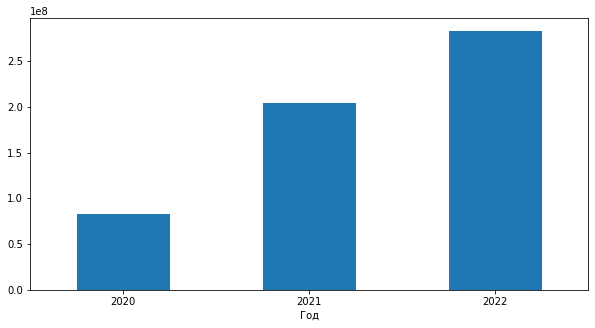

In [ ]:
year_new_cases.plot(y='Новые_случаи', kind='bar', figsize=(10, 5), legend=False)
plt.xticks(rotation = 0)
print('Число выявленных случаев за год, ед.')

In [ ]:
max_elements = year_new_cases.max()
max_elements

Новые_случаи    282872650
Смерти            3521512
dtype: int64

Число смертей за год, ед.


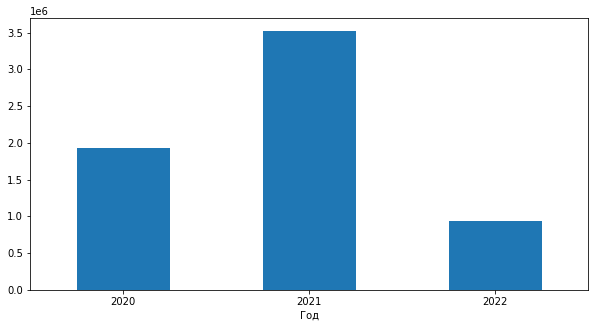

In [ ]:
year_new_cases.plot(y='Смерти', kind='bar', figsize=(10, 5), legend=False)
plt.xticks(rotation = 0)
print('Число смертей за год, ед.')

---

## 3. Число выявленных новых случаев заболевания и смертности в разрезе регионов

In [ ]:
print('Число выявленных случаев и смертей за год в разрезе регионов, ед. случаев')
region_new_cases = data.pivot_table(index=['Регион', 'Год'], aggfunc={'Новые_случаи':sum, 'Смерти':sum}).sort_values(by='Регион')
display((region_new_cases).reset_index())
print('По состянию на', tomorrow)

Число выявленных случаев и смертей за год в разрезе регионов, ед. случаев


,Регион,Год,Новые_случаи,Смерти
0,AFRO,2020,1900687,42290
1,AFRO,2021,5405787,113898
2,AFRO,2022,1886964,17775
3,AMRO,2020,35795320,956007
4,AMRO,2021,68135608,1461335
5,AMRO,2022,65410609,366420
6,EMRO,2020,4912291,120880
7,EMRO,2021,12254676,195342
8,EMRO,2022,5391127,28528
9,EURO,2022,137331195,361958


По состянию на 2022-07-27


Распределение новых случаев заболевания
по регионам, за всё время наблюдений


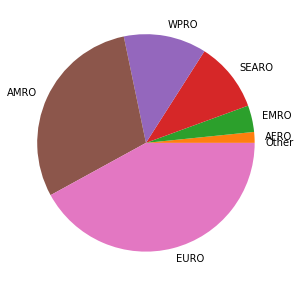

In [ ]:
print('Распределение новых случаев заболевания')
print('по регионам, за всё время наблюдений')
region_year_cases = region_new_cases.pivot_table(index=['Регион'], aggfunc={'Новые_случаи':sum}).sort_values(by='Новые_случаи')
region_year_cases.plot(kind='pie', figsize=(5, 5), legend=False, subplots=True)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

Распределение числа смертей по регионам,
за всё время наблюдений


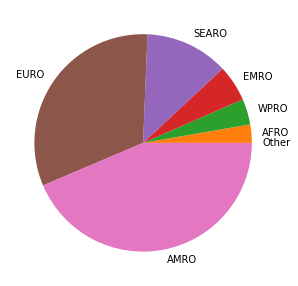

In [ ]:
print('Распределение числа смертей по регионам,')
print('за всё время наблюдений')
region_year_cases = region_new_cases.pivot_table(index=['Регион'], aggfunc={'Смерти':sum}).sort_values(by='Смерти')
region_year_cases.plot(kind='pie', figsize=(5, 5), legend=False, subplots=True)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

---

## 4. Число выявленных новых случаев заболевания и смертность в разрезе стран

### 4.1. Топ-10 стран по числу заболевших за всё время   
Выведим топ-10 стран по общему числу зарегестированнх случаев заболевания за всё время.

In [ ]:
print('Топ-10 стран по числу заболевших, ед. случаев')
country_new_cases = data.pivot_table(index=['Страна'], aggfunc={'Новые_случаи':sum}).nlargest(10, columns='Новые_случаи')
display((country_new_cases).reset_index())
print('По состянию на', tomorrow)

Топ-10 стран по числу заболевших, ед. случаев


,Страна,Новые_случаи
0,United States of America,89428046
1,India,43938764
2,Brazil,33621965
3,France,32664720
4,Germany,30598385
5,The United Kingdom,23213017
6,Italy,20772833
7,Republic of Korea,19446946
8,Russian Federation,18554036
9,Türkiye,15524071


По состянию на 2022-07-27


### 4.2. Топ-10 стран по числу умерших за всё время   
1. Выведем топ-10 стран по числу умерших за всё время наблюдений.   
1. Посчитаем долю умерших от общего числа заболевших - уровень летальности (% умерших от общего числа счлучаев заболевания).

In [ ]:
print('Топ-10 стран по числу умерших, ед. случаев')
country_deaths = data.pivot_table(index=['Страна'], aggfunc={'Смерти':sum,'Новые_случаи':sum}).nlargest(10, columns='Смерти')
country_deaths['Летальность, %'] = ((country_deaths['Смерти']/country_deaths['Новые_случаи'])*100).round(2)
display((country_deaths).reset_index())
print('По состянию на', tomorrow)

Топ-10 стран по числу умерших, ед. случаев


,Страна,Новые_случаи,Смерти,"Летальность, %"
0,United States of America,89428046,1017366,1.14
1,Brazil,33621965,677143,2.01
2,India,43938764,526167,1.20
3,Russian Federation,18554036,382272,2.06
4,Mexico,6628541,327109,4.93
5,Peru,3845093,214071,5.57
6,The United Kingdom,23213017,182727,0.79
7,Italy,20772833,171232,0.82
8,Indonesia,6178873,156929,2.54
9,France,32664720,148254,0.45


По состянию на 2022-07-27


### 4.3. Топ-10 стран по уровню смертности за всё время     
 Выведем топ-10 стран по ранее расчитанному уровню летальности.

In [ ]:
print('Топ-10 стран по уровню смертности')
mortality_rate = country_deaths.nlargest(10, columns='Летальность, %')
display((mortality_rate).reset_index())
print('По состянию на', tomorrow)

Топ-10 стран по уровню смертности


,Страна,Новые_случаи,Смерти,"Летальность, %"
0,Peru,3845093,214071,5.57
1,Mexico,6628541,327109,4.93
2,Indonesia,6178873,156929,2.54
3,Russian Federation,18554036,382272,2.06
4,Brazil,33621965,677143,2.01
5,India,43938764,526167,1.20
6,United States of America,89428046,1017366,1.14
7,Italy,20772833,171232,0.82
8,The United Kingdom,23213017,182727,0.79
9,France,32664720,148254,0.45


По состянию на 2022-07-27


---

## 5. Месячные данные о числе выявленных новых случаев заболевания и смертность в целом по миру

Число выявленных случаев в мире по месяцам, ед.


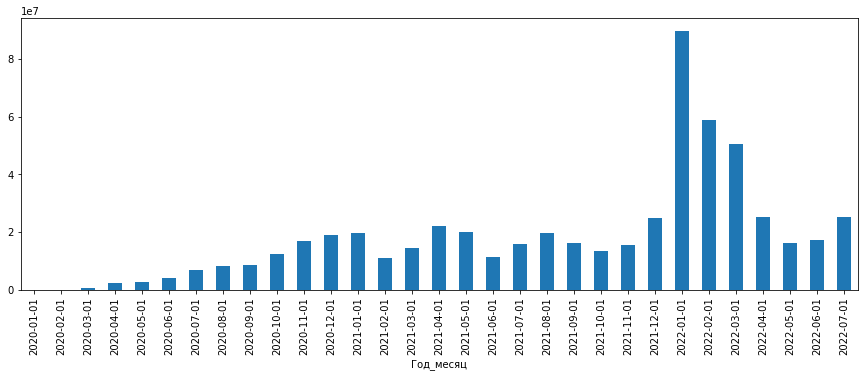

In [ ]:
month_new_cases = data.pivot_table(index=['Год_месяц'], aggfunc={'Новые_случаи':sum}).sort_values(by='Год_месяц')
month_new_cases.plot(y='Новые_случаи', kind='bar', figsize=(15, 5), legend=False)
plt.xticks(rotation = 90)
print('Число выявленных случаев в мире по месяцам, ед.')

Число смертей в мире по месяцам, ед.


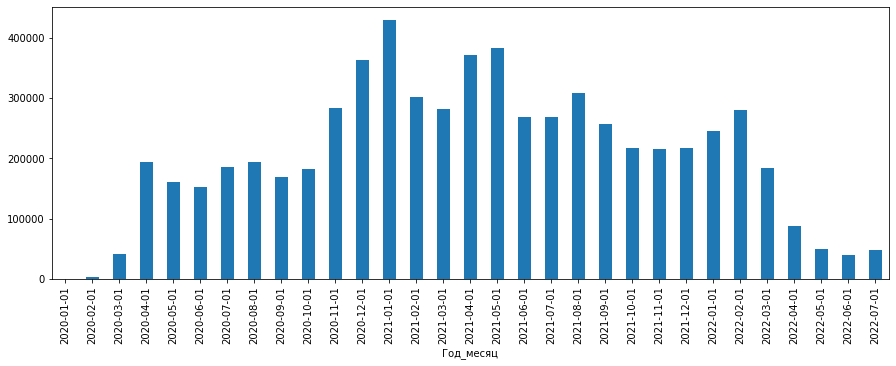

In [ ]:
month_deaths = data.pivot_table(index=['Год_месяц'], aggfunc={'Смерти':sum}).sort_values(by='Год_месяц')
month_deaths.plot(y='Смерти', kind='bar', figsize=(15, 5), legend=False)
plt.xticks(rotation = 90)
print('Число смертей в мире по месяцам, ед.')

---

## 5. Данные о числе выявленных новых случаев заболевания и смертность в России

### 5.1. Годовые данные

In [ ]:
new_cases_total = data.loc[:, 'Новые_случаи'].sum()
ru_new_cases_total = ru_data.loc[:, 'Новые_случаи'].sum()
deaths_total = data.loc[:, 'Смерти'].sum()
ru_deaths_total = ru_data.loc[:, 'Смерти'].sum()
print('За всё время наблюдений:')
print('-'*66)
print((ru_new_cases_total/(new_cases_total/100)).round(2), '% общемирового числа случаев заболевания COVID-19 приходится на Россию')
print('-'*66)
print((ru_deaths_total/(deaths_total/100)).round(2), '% общемирового числа умерших от COVID-19 приходится на Россию')
print('-'*66)
print((ru_deaths_total/(ru_new_cases_total/100)).round(2), '% - уровень летальности в России')
print('-'*66)
print('По данным ВОЗ на', tomorrow)

За всё время наблюдений:
------------------------------------------------------------------
3.26 % общемирового числа случаев заболевания COVID-19 приходится на Россию
------------------------------------------------------------------
5.99 % общемирового числа умерших от COVID-19 приходится на Россию
------------------------------------------------------------------
2.06 % - уровень летальности в России
------------------------------------------------------------------
По данным ВОЗ на 2022-07-27


In [ ]:
print('Число выявленных случаев и смертей в России за год, ед.')
ru_year_new_cases = ru_data.pivot_table(index=['Год'], aggfunc={'Новые_случаи':sum, 'Смерти':sum}).sort_values(by='Год')
display((ru_year_new_cases).reset_index())
print('По состянию на', tomorrow)

Число выявленных случаев и смертей в России за год, ед.


,Год,Новые_случаи,Смерти
0,2020,3159297,57019
1,2021,7340685,251841
2,2022,8054054,73412


По состянию на 2022-07-27


Число выявленных случаев в России за год, ед.


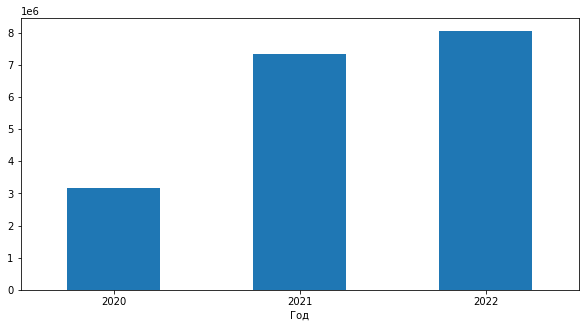

In [ ]:
ru_year_new_cases.plot(y='Новые_случаи', kind='bar', figsize=(10, 5), legend=False)
plt.xticks(rotation = 0)
print('Число выявленных случаев в России за год, ед.')

Число смертей в России за год, ед.


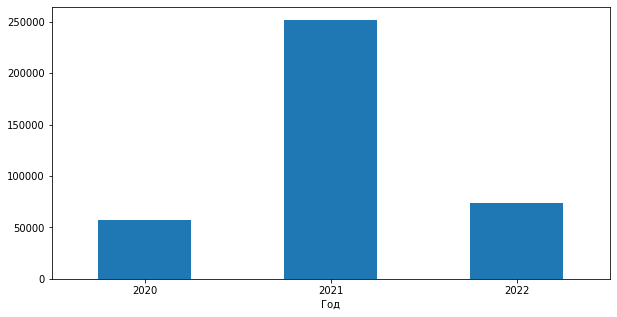

In [ ]:
ru_year_new_cases.plot(y='Смерти', kind='bar', figsize=(10, 5), legend=False)
plt.xticks(rotation = 0)
print('Число смертей в России за год, ед.')

### 5.2. Помесячные данные

Число выявленных случаев в России по месяцам, ед.


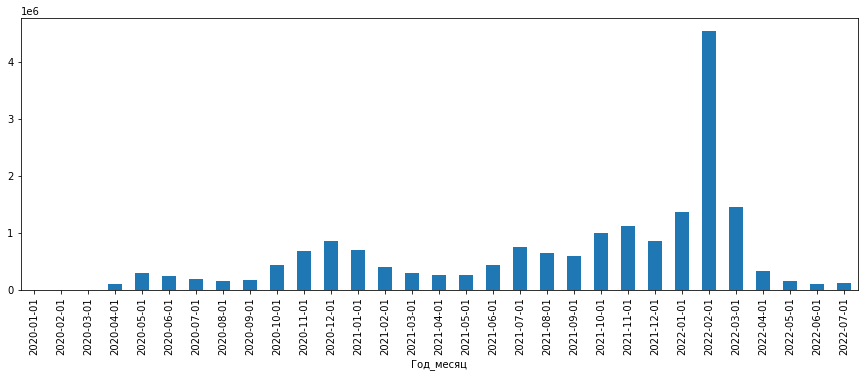

In [ ]:
ru_month_new_cases = ru_data.pivot_table(index=['Год_месяц'], aggfunc={'Новые_случаи':sum}).sort_values(by='Год_месяц')
ru_month_new_cases.plot(y='Новые_случаи', kind='bar', figsize=(15, 5), legend=False)
plt.xticks(rotation = 90)
print('Число выявленных случаев в России по месяцам, ед.')

Число смертей в России по месяцам, ед.


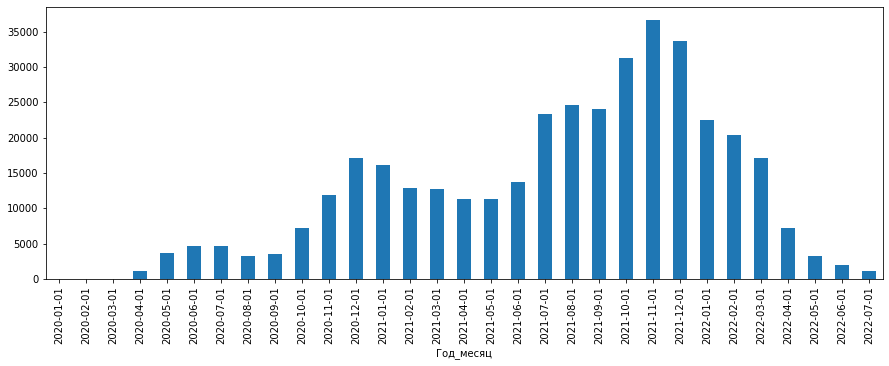

In [ ]:
ru_month_deaths = ru_data.pivot_table(index=['Год_месяц'], aggfunc={'Смерти':sum}).sort_values(by='Год_месяц')
ru_month_deaths.plot(y='Смерти', kind='bar', figsize=(15, 5), legend=False)
plt.xticks(rotation = 90)
print('Число смертей в России по месяцам, ед.')